In [75]:
import numpy as np
import matplotlib.pyplot as plt
import dill as pickle

from math import exp

In [32]:
class Layer:
    def __init__(self):
        self.name = None
        self.x = None
        self.y = None
    
    def forward(self, x):
        pass

    def backward(self, gradient, lr):
        pass

In [33]:
class LinearLayer(Layer):
    
    def __init__(self, x_size, y_size):
        self.name = 'Linear_Layer'
        self.weights = np.random.rand(y_size, x_size)
        self.bias = np.random.rand(y_size, 1)
    
    def forward(self, x):
        self.x = x
        return np.dot(self.weights, self.x) + self.bias
    
    def backward(self, gradient, lr=0.01):
        weights_grad = np.dot(gradient, self.x.T)
        x_grad = np.dot(self.weights.T, gradient)
        self.weights -= lr * weights_grad
        self.bias -= lr * gradient
        return x_grad
    
        

In [34]:
class SigmoidActivation(Layer):
    def __init__(self):
        self.name = 'Sigmoid_Activation'
        self.sigmoid = lambda x : 1. / (1. + np.exp(-x))
        self.sigmoid_grad = lambda x : self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def forward(self, x):
        self.x = x
        return self.sigmoid(self.x)
    
    def backward(self, gradient, lr=0.01):
        return np.multiply(gradient,self.sigmoid_grad(self.x))
    

In [35]:
class TanhActivation(Layer):
    def __init__(self):
        self.name = 'Tanh_Activation'
        self.tanh = lambda x : np.tanh(x)
        self.tanh_grad = lambda x : 1. - np.tanh(x)**2
    
    def forward(self, x):
        self.x = x
        return self.tanh(self.x)
    
    def backward(self, gradient, lr=0.01):
        return np.multiply(gradient,self.tanh_grad(self.x))
    

In [36]:
class CrossEntropyLoss:
    def __init__(self):
        self.name = 'CrossEntropyLoss'

    def cross_entropy(self, y_actual, y_pred):
        return np.mean(-y_actual * np.log(y_pred))
    
    def cross_entropy_grad(self, y_actual, y_pred):
        return y_actual - y_pred
    
    def forward(self, y_actual, y_pred):
        self.y = y_pred
        return self.cross_entropy(y_actual, y_pred)
    
    def backward(self, y_actual, y_pred):
        return self.cross_entropy_grad(y_actual, y_pred)

In [79]:
class SoftMax:
    def __init__(self):
        self.name = 'SoftMax'

    def forward(self, y_pred):
        cls_prob = np.exp(y_pred)
        tot_prob = np.sum(cls_prob)
        return cls_prob/tot_prob
    
    def backward(self, y_pred):
        return y_pred

In [37]:
class Sequential(Layer):
    def __init__(self, network=[]):
        self.name = 'Sequential'
        self.network = network
        
    def forward(self, x):
        out = x
        for layer in self.network:
            #print(f'''layer-{layer.name} shape:{out.shape}''')
            out = layer.forward(out)
        return out

    def backward(self, gradient, lr = 0.01):
        grad = gradient
        for layer in reversed(self.network):
            grad = layer.backward(grad, lr)
        return grad
    
        

In [38]:

EARLY_STOP_LIMIT = 5

def early_stopping_required(loss_list = []):
    if len(loss_list) >= EARLY_STOP_LIMIT + 1:
        recent_loss_val = loss_list[-1]
        count = 0
        for loss in loss_list[-5:]:
            if recent_loss_val >= loss:
                count+=1
        if count == 5:
            print('Stopping the model Training early')
            return True
        return False

def train(sequential_network, x_train, y_train, epochs = 2000, lr =0.01):
    loss_list =[]
    for itr in range(epochs):
        error = 0
        for x, y_actual in zip(x_train, y_train):
            y_pred = sequential_network.forward(x)
            #print('y---pred',y_pred)
            loss = CrossEntropyLoss()
            error+= loss.cross_entropy(y_actual, y_pred)
            #print('error: ',error)
            gradient_loss = loss.cross_entropy_grad(y_actual, y_pred)
            sequential_network.backward(gradient_loss,lr=0.01)
        error /= len(x_train)
        loss_list.append(error)
        #Early Stopping
        if early_stopping_required(loss_list):
            epochs = itr + 1
            print(f'''Early Stopping the Model Training at Epoch:{itr}''')
            break
        #print(f"{itr + 1}/{epochs}, error={error}")
    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax.plot(np.arange(0,epochs),np.array(loss_list).reshape(-1))
    ax.set_title('Training Loss')
    return sequential_network

def predict(model, x_test,y_actual):
    score = 0
    for idx, test_sample in enumerate(x_test):
        y_pred = model.forward(test_sample)
        if np.argmax(y_pred) == np.argmax(y_actual[idx]):
            score+=1
    return score/len(y_actual)
    

def save(model, filename):
    pickle.dump(model,open(filename, 'wb'))

def load(filename):
    return pickle.load(open(filename, 'rb'))

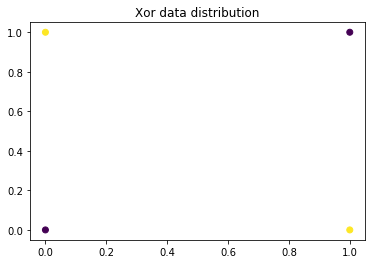

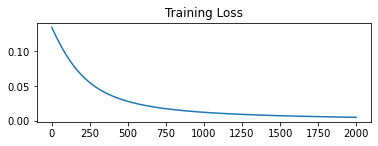

In [39]:
# Define XOR inputs -- prepend a constant of 1 for bias multiplication
samples = np.array([[0, 0],
                    [0, 1],
                    [1, 0],
                    [1, 1]])
targets = np.array([[0], [1], [1], [0]])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(samples[:, 0], samples[:, 1], c=targets)
ax.set_title('Xor data distribution')

model = Sequential([
    LinearLayer(2,2),
    SigmoidActivation(),
    LinearLayer(2,1),
    SigmoidActivation() ])

trained_model = train(model,samples.reshape(4,2,1),targets.reshape(4,1,1),epochs=2000)


<h3>Save and Load the Model</h3>

In [40]:
filename = 'XOR_solved.w'
save(trained_model,filename)
mp = load(filename)

In [41]:
predict(trained_model,samples.reshape(4,2,1),targets)

1.0

In [43]:
predict(mp,samples.reshape(4,2,1),targets)

1.0

# Hand Written Digit Recognition

In [13]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [14]:
mnist_samples, mnist_targets = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

In [84]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

def preprocess(samples, targets):
    # reshape and normalization
    samples = samples.reshape(samples.shape[0], 28 * 28, 1)
    samples = samples.astype("float32") / 255
    #convery to numbers
    conv_targets = [int(num) for num in targets]
    conv_targets = np.array(conv_targets)
    targets_vect = get_one_hot(conv_targets,10)
    targets_vect = targets_vect.reshape(targets_vect.shape[0], 10, 1)
    return samples, targets_vect

def predict_mnist(model, x_test,y_actual):
    score = 0
    for idx, test_sample in enumerate(x_test):
        y_pred = model.forward(test_sample)
        softmax = SoftMax()
        probs = softmax.forward(y_pred)
        #print(f'''Actual value - {np.argmax(y_actual[idx])} Predicted Value- {np.argmax(probs)}''')
        if np.argmax(probs) == np.argmax(y_actual[idx]):
            score+=1
    return score/len(y_actual)

def plot_validation_loss(model, x_val,y_val):
    error_list = [] 
    for idx, val_sample in enumerate(x_val):
        val_pred = model.forward(val_sample)
        loss = CrossEntropyLoss()
        error = loss.cross_entropy(val_pred, y_val[idx])
        error_list.append(error)
    fig = plt.figure()
    ax = fig.add_subplot(221)
    ax.plot(np.arange(0,len(x_val)),np.array(error_list).reshape(-1))
    ax.set_title('Validation Loss')
    

X, Y = preprocess(mnist_samples,mnist_targets)


In [67]:
train_split,combine_split,train_y_split,combine_y_split = train_test_split(X, Y,test_size=0.2, random_state=123)
val_split,test_split,val_y_split,test_y_split = train_test_split(combine_split, combine_y_split,test_size=0.5, random_state=123)

In [47]:
# Training Sample
print('*'*25)
print('Train sample split shape', train_split.shape)
print('Train targets split shape' ,train_y_split.shape)
print('*'*25)
# Validation Samples
print('Validation sample split shape' ,val_split.shape)
print('Validation targets split shape', val_split.shape)
print('*'*25)
# Test Samples
print('Test sample split shape' ,test_split.shape)
print('Test targets split shape', test_split.shape)

*************************
Train sample split shape (56000, 784, 1)
Train targets split shape (56000, 10, 1)
*************************
Validation sample split shape (7000, 784, 1)
Validation targets split shape (7000, 784, 1)
*************************
Test sample split shape (7000, 784, 1)
Test targets split shape (7000, 784, 1)


Stopping the model Training early
Early Stopping the Model Training at Epoch:5


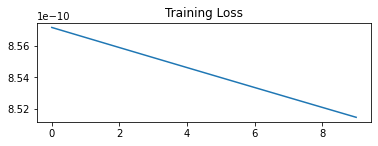

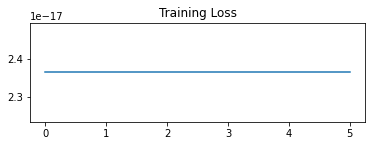

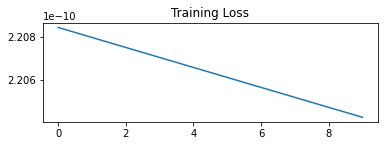

In [62]:
mnist_model_1 = model = Sequential([
    LinearLayer(28*28,40),
    SigmoidActivation(),
    LinearLayer(40,10),
    SigmoidActivation()])

mnist_model_2 = model = Sequential([
    LinearLayer(28*28,40),
    TanhActivation(),
    LinearLayer(40,10),
    TanhActivation()])

mnist_model_3 = model = Sequential([
    LinearLayer(28*28,40),
    TanhActivation(),
    LinearLayer(40,20),
    TanhActivation(),
    LinearLayer(20,10),
    TanhActivation()])

trained_model_1 = train(mnist_model_1,train_split,train_y_split,epochs=10, lr=0.01)

trained_model_2 = train(mnist_model_2,train_split,train_y_split,epochs=10, lr=0.01)

trained_model_3 = train(mnist_model_3,train_split,train_y_split,epochs=10, lr=0.01)

C:\Users\durga\AppData\Local\Temp\ipykernel_21064\1093031213.py:6: RuntimeWarning: divide by zero encountered in log
  return np.mean(-y_actual * np.log(y_pred))
C:\Users\durga\AppData\Local\Temp\ipykernel_21064\1093031213.py:6: RuntimeWarning: divide by zero encountered in log
  return np.mean(-y_actual * np.log(y_pred))
C:\Users\durga\AppData\Local\Temp\ipykernel_21064\1093031213.py:6: RuntimeWarning: divide by zero encountered in log
  return np.mean(-y_actual * np.log(y_pred))


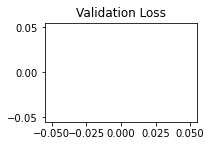

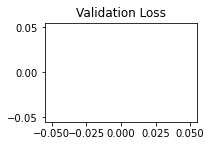

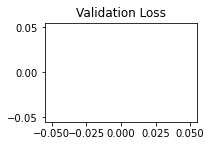

In [89]:
plot_validation_loss(trained_model_1, val_split,val_y_split)
plot_validation_loss(trained_model_2, val_split,val_y_split)
plot_validation_loss(trained_model_3, val_split,val_y_split)

In [90]:
score_model_1 = predict_mnist(trained_model_1,test_split,test_y_split)
print('Model_1 Score: ',round(score_model_1,4))

score_model_2 = predict_mnist(trained_model_2,test_split,test_y_split)
print('Model_2 Score: ',round(score_model_2,4))

score_model_3 = predict_mnist(trained_model_3,test_split,test_y_split)
print('Model_3 Score: ',round(score_model_3,4))


Model_1 Score:  0.0907
Model_2 Score:  0.093
Model_3 Score:  0.1113


In [86]:
mnist_file = 'mnist_solved.w'
save(trained_model_2,mnist_file)


In [85]:
mnist_saved_model =  load(mnist_file )